In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pylbm import lbm

In [9]:
# shows how many cpus are usable for quadratic
cpus = []
for i in range(1,30):
    if 300%i == 0:
        cpus.append(i*i)
print(cpus)

[1, 4, 9, 16, 25, 36, 100, 144, 225, 400, 625]


In [44]:
# print((np.array(cpus) / 2))
# print((np.array(cpus) / 4))
# print((np.array(cpus) / 6))
# print((np.array(cpus) / 8))
# indices = [1,3,5,6,7]
# print((np.array(cpus) / 2)[indices].astype(int))
# print((np.array(cpus) / 4)[indices].astype(int))
# print((np.array(cpus) / 6)[[5,7]].astype(int))
# print((np.array(cpus) / 8)[[3,7,9]].astype(int))


In [58]:
combinations = [(2, (2, 8, 18, 32)),(4,(1,4, 9, 16, 25, 36))]
res_nodes =[]
for comb in combinations:
    res_cpu = []
    for cpu in comb[1]:
        if not (comb[0] * cpu) in cpus:
            print("ERROR!!!")
            print(comb[0] * cpu)
        path ='{}_nodes/slurm_nodes_{}_ntasks_{}.out'.format(comb[0],comb[0], cpu)
        with open(path, 'r') as reader:
            # Read and print the entire file line by line
            line = reader.readline()
            while line != '':  # The EOF char is an empty string
                if "Wall-clock" in line:
                    line = line.split(": ")[1]
                    # print("{} nodes and {} cpus \t {}".format(comb[0], cpu,line))
                    time = line.split(":")
                    sec = int(time[2]) + int(time[1]) *60 + int(time[0]) *3600
                    res_cpu.append(sec)
                    # print(sec)
                line = reader.readline()
    res_nodes.append(res_cpu)

ERROR!!!
64
ERROR!!!
64


/tmp/ipykernel_590/2812054836.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.array(combinations[num_com][1])*2, res_nodes[num_com],'--bo', color='tab:blue', label='nodes=2')
/tmp/ipykernel_590/2812054836.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.array(combinations[num_com][1])*4, res_nodes[num_com],'--bo', color='tab:orange', label='nodes=4')


[ 4 16 36 64]
[ 2  8 18 32 50 72]


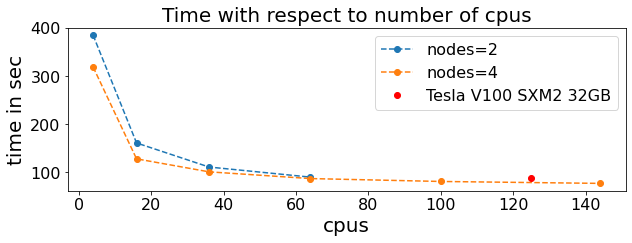

In [59]:

fig, ax = plt.subplots(figsize=(10,3))

font_size = 20
plt.rc('font', size=16) 
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)

num_com = 0
node = combinations[num_com][0]
plt.plot(np.array(combinations[num_com][1])*2, res_nodes[num_com],'--bo', color='tab:blue', label='nodes=2')
print(np.array(combinations[num_com][1])*2)

num_com = 1
node = combinations[num_com][0]
plt.plot(np.array(combinations[num_com][1])*4, res_nodes[num_com],'--bo', color='tab:orange', label='nodes=4')
print(np.array(combinations[num_com][1])*2)

plt.plot(125, 60+27.223, 'ro', label='Tesla V100 SXM2 32GB')

ax.legend()
ax.set_title("Time with respect to number of cpus")
ax.set_xlabel("cpus")
ax.set_ylabel("time in sec")
lbm.save_fig(fig, name="m7.pgf")
plt.show()
plt.close()


# with GPU and double/float64
GV100GL [Tesla V100 SXM2 32GB]

time python lbm_t.py

real    1m28.899s  
user    1m27.223s  
sys     0m2.480s

In [48]:
print("2 nodes: {}\t4 nodes: {}\tGPU: {}".format(res_nodes[0][-1],res_nodes[1][-1],87))

2 nodes: 90	4 nodes: 77	GPU: 87
